<h1><center>STAT/CSE 416 Section 9: Pytorch and Neural Networks</center></h1>
<center><b>Section:</b>AA/AB</center>
<center><b>Instructor:</b>Datong Zhou</center>
<center><b>TA:</b>Long Nguyen</center>
<center><b>Date:</b>Nov 30th, 2023</center>

*Adapted from slides and notebooks from previous STAT/CSE 416 TAs.*

# Import Statements

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt              # For plotting
import torch                                 # Overall PyTorch import
import torch.nn as nn                        # For specifying neural networks
import torch.nn.functional as F              # For common functions
import torch.optim as optim                  # For optimizizing model parameters
import torchvision.datasets as datasets      # To download data
import torchvision.transforms as transforms  # For pre-processing data
import seaborn as sns

sns.set()

# Basic Tensors

Tensors are basically a specialized data structure that are similar to arrays and matrices. While their are distinctions, they are not vital to the material of this course. In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs or other specialized hardware to accelerate computing.


In [2]:
# Initialization Strategies

# Directly from Data
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

# From a Numpy Array
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

print(x_np)

# From another Tensor
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

# Using Shape
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

tensor([[1, 2],
        [3, 4]])
tensor([[1, 2],
        [3, 4]])
Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.6507, 0.3939],
        [0.2737, 0.6894]]) 

Random Tensor: 
 tensor([[0.8641, 0.9028, 0.1757],
        [0.8228, 0.9731, 0.0477]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [3]:
# Attributes

tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

#cuda=torch.device('cuda')
#tensor.to(device=cuda)


Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


# Data

We are using the MNIST Dataset.

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

trainset = datasets.MNIST(root='./data', train=True, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                           shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False, download=True,
                           transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=36,
                                          shuffle=False, num_workers=2)
print(trainset)

100%|██████████| 9912422/9912422 [00:00<00:00, 132812351.24it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35091452.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50892182.80it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4432417.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


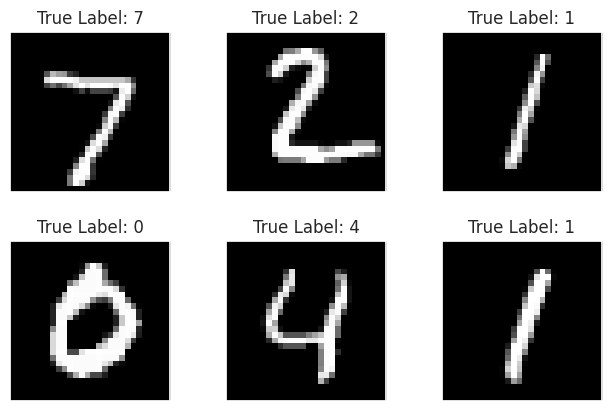

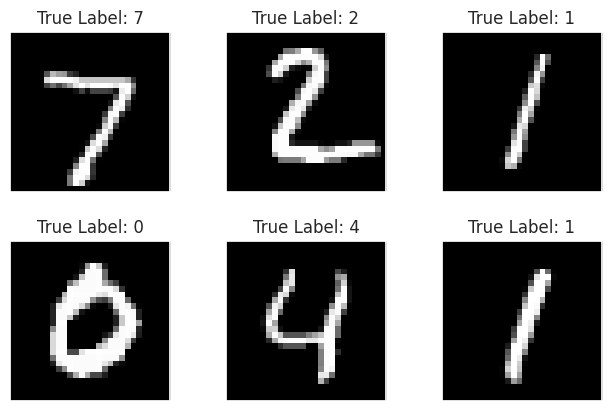

In [5]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("True Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Defining a Neural Network

Neural networks are fairly complex models, taken in their entirety, capable of very complex data modeling. Despite this, they are assembled from simple mathematical components, a process that we as users will have to manually guide.

A neural net consists of familar input and output layers, identical to the input and output we would see from most other ML models, sandwiching one or more linear, convolution, deconvolution, or other types of layers.

![image.png](attachment:image.png)

(Image source: https://www.ibm.com/topics/neural-networks)

To understand the different layers in a Neural Network see the following documentation: https://pytorch.org/docs/stable/nn.html#linear-layers.

To create a neural network, two functions need be defined (three, but the third we get for free).

<b>__init__</b> works as it does in any other python function; initializing any necessary data structures or objects necessary for future functionality. Here we use it to initialize each of the pieces of our neural network.

<b>forward</b> defines the forward step of the neural network; IE: how do we take input $X$ and extra from it output $y$; the forward step does this processing by stepping through each layer of the neural network.

<b>backward</b> defines the backward step of the neural network; used for optimizing the parameters of the model, typically using gradient descent methods. For our purposes, we can rely on autograd to handle this step for us.

Example Applying a Linear Layer to the Neural Network

In [6]:
class Net_1(nn.Module):
  def __init__(self):
    super(Net_1, self).__init__()
    self.fc1 = nn.Linear(1 * 28, 3)
    self.fc2 = nn.Linear(3, 2)

  def forward(self, x):
    #x = x.view(-1, 1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x


print(example_data.shape)
net=Net_1()
#example_data.view(-1,1).shape
result=net.forward(example_data)
print(result.shape)
#36,1,28,3

torch.Size([36, 1, 28, 28])
torch.Size([36, 1, 28, 3])


## Types of Layers

There are different types of layers that can be added to a neural network, and while we won't detail them all here we will opt to focus on three types: Linear, convolution, and drop out.

### Linear Layers

Linear layers function as a simple linear relationship - Input values are scaled by the model weights before being linearly combined into a pre-defined number of output values.

![image.png](attachment:image.png)

(Image from https://www.perceptilabs.com/)

### Convolution Layers

Convolution layers are more complex. A convolution layer will taken in imput and break it down in (typically partially overlapping) segments of equal size. For each of these segments, a convolution is applied, essentially a mask over the segment that measures agreement with a fixed pattern.

One can imagine the case of examining numbers, applying a convolution to the top and bottom half of the image that is a convolution of a circle. Numbers like 6 and 9 would have high values of this convolution for the bottom and top half, respectively, while 8 would have a high value for both. A number like 4 will produce a higher value for its top half convolution output (as the shape of the top of a 4 is closer to a circle) than 7 or 1. In the end, the convolution in this example is a measure of 'circularness'.

Below is an example of a simple 'straight line' convolution applied to a very strictly drawn number 4.

![image.png](attachment:image.png)

![image.png](attachment:image.png)

(Example of a convolution from https://www.jeremyjordan.me/convolutional-neural-networks/)

### Dropout Layers

Drop out layers are simple layers that perform a drop out of neurons in the network according to, typically, a random process. Threshold based dropout layers are also common. In practice drop out layers serve to help prevent overfitting.

![image.png](attachment:image.png)

(Image from https://www.baeldung.com/)

Let's try combining each of these layer types into a single network.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) #kernel_size = 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) #stride = can define the stride size
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) #50 is the hyperparameter that we define
        self.fc2 = nn.Linear(50, 10) #10 classes of the last layer

    #2D convolutional :[batch size, channel size, image size (h,w)]

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)# don't  need to initialize any weights
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2) #dont have any learnable weights
        x = F.relu(x)

        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


We must define each of our layers in the initialization of our neural network class. In the forward function we define the forward step through the network, passing the same varaible $x$ along as we transform it at each stage. Note that the order of operations here is vital to confirm that we process the network in the correct order, otherwise we will quickly encounter dimensionality issues when dimensions of the network conflict with one another. The backwards function is already defined for you using autograd.

# Training a Classifier

The following code will implement the neural network defined and try to fit on the MNIST data set. Note that if available, it will utilize your GPU (referred to as 'cuda' code) for efficient computation.

In [8]:
# First defining a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

loss_plot = []

# Training
for epoch in range(3):  # loop over the dataset multiple times, here we chose 3 but can make this bigger

    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
          net = net.cuda()
          inputs = inputs.cuda()
          labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad() 

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 100))

            loss_plot.append(running_loss / 100)
            running_loss = 0.0

print('Finished Training')


<ipython-input-7-2d53760dc35c>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1,     0] loss: 0.023
[1,   100] loss: 2.299
[1,   200] loss: 2.267
[1,   300] loss: 2.215
[1,   400] loss: 2.085
[2,     0] loss: 0.017
[2,   100] loss: 1.560
[2,   200] loss: 1.273
[2,   300] loss: 1.039
[2,   400] loss: 0.893
[3,     0] loss: 0.009
[3,   100] loss: 0.756
[3,   200] loss: 0.667
[3,   300] loss: 0.635
[3,   400] loss: 0.593
Finished Training


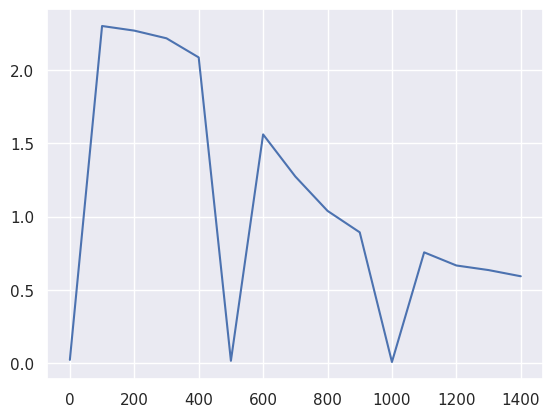

In [9]:
# Plot of Loss Function
iters = [i for i in range(0, 1500, 100)]

plt.plot(iters, loss_plot)

Note that, as with other ML techniques, there is considerable input from us the user in defining these models. The layers, order of layers, and parameterization of layers can all be controlled to define models that more accurate reflect the data. Don't forget that in practice we always want to utilize training/testing/validation data splits to ensure we aren't overparameterizing and overfitting to our data.

If you want some practice, try modifiying the neural network defined above to add layers, modifying the size of layers, or any other modifications you can think to do to try and improve the fit of the model.

# Sources

Notebook uses the work of Gregor Koehler, see the link below to their article for more information on the results of the model.
* https://nextjournal.com/gkoehler/pytorch-mnist \\
Note uses documentation from PyTorch, see the link below.
* https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html \\
Other Helpful Resources
* https://www.youtube.com/watch?v=YRhxdVk_sIs
* https://www.youtube.com/watch?v=-SA8BmGvWYE

